# DETECCIÓN DE LA LEUCEMIA LINFOBLÁSTICA AGUDA
La leucemia linfoblástica aguda (LLA) es un tipo de cáncer hematológico caracterizado por la proliferación descontrolada de linfoblastos inmaduros en la médula ósea, la sangre y otros órganos. Este trastorno impide la producción adecuada de células sanguíneas normales, lo que provoca síntomas como anemia, infecciones recurrentes y sangrados anormales. [1]

El cáncer es una de las principales causas de mortalidad entre niños y adolescentes en todo el mundo; cada año se diagnostica cáncer a aproximadamente 274.000 niños de entre 0 y 19 años. [2]

En América Latina y el Caribe, se estima que alrededor de 30.000 niñas, niños y adolescentes menores de 19 años resultarán afectados por el cáncer anualmente. De ellos, casi 10.000 fallecerán a causa de esta enfermedad.
En los países de ingresos altos, más del 80% de los niños afectados de cáncer se curan, pero en muchos países de ingresos medianos y bajos la tasa de curación es de aproximadamente el 20%.[3]

Las defunciones evitables debidas a los cánceres infantiles en los países de ingresos medianos y bajos se producen a consecuencia de la falta de diagnóstico, los diagnósticos incorrectos o tardíos, las dificultades para acceder a la atención sanitaria, el abandono del tratamiento, la muerte por toxicidad y las mayores tasas de recidivas. [3]



# Frotis de Sangre
Un frotis de sangre es una prueba de laboratorio que se utiliza para examinar las células sanguíneas bajo un microscopio. Consiste en tomar una pequeña muestra de sangre del paciente, extenderla sobre un portaobjetos y luego teñirla con colorantes especiales para poder visualizar las diferentes células sanguíneas (glóbulos rojos, glóbulos blancos y plaquetas) y observar cualquier anomalía en su forma, tamaño o cantidad.

# OBEJTIVOS DEL PROYECTO

1. Explorar y comprender el dataset: Obtener una visión general del dataset de imágenes de frotis de sangre, incluyendo el número de imágenes, las clases disponibles (sano, leucemia), y el preprocesamiento necesario.

2. Preprocesamiento de imágenes: Aplicar técnicas de procesamiento de imágenes para preparar los datos para el modelo de regresión logística, como:
Conversión de imágenes a escala de grises.
Reducción de ruido y mejora de la calidad de las imágenes.
Normalización de los valores de píxeles.

3. Extracción de características relevantes: Identificar características importantes de las imágenes de frotis de sangre que puedan ayudar en la clasificación de leucemia, como texturas, formas celulares y patrones visuales.

4. Implementación del modelo de regresión logística: Desarrollar un modelo de regresión logística para la clasificación binaria (leucemia vs. sano) utilizando las características extraídas.

5. Entrenamiento y evaluación del modelo: Dividir el dataset en conjuntos de entrenamiento y prueba, entrenar el modelo de regresión logística y evaluar su desempeño usando métricas como precisión, recall, F1-score y la matriz de confusión.

6. Optimización del modelo: Ajustar los hiperparámetros del modelo de regresión logística para mejorar su rendimiento.

7. Visualización de resultados: Crear gráficas y visualizaciones para mostrar los resultados del modelo, como las curvas ROC y las predicciones de clasificación sobre imágenes de prueba.

8. Análisis de errores y mejora del modelo: Analizar los errores del modelo y explorar posibles mejoras, como el ajuste de características o la inclusión de más datos de entrenamiento.

9. Documentación y presentación de resultados: Redactar un informe detallado que explique el proceso, las técnicas utilizadas, los resultados obtenidos y las conclusiones.

In [1]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


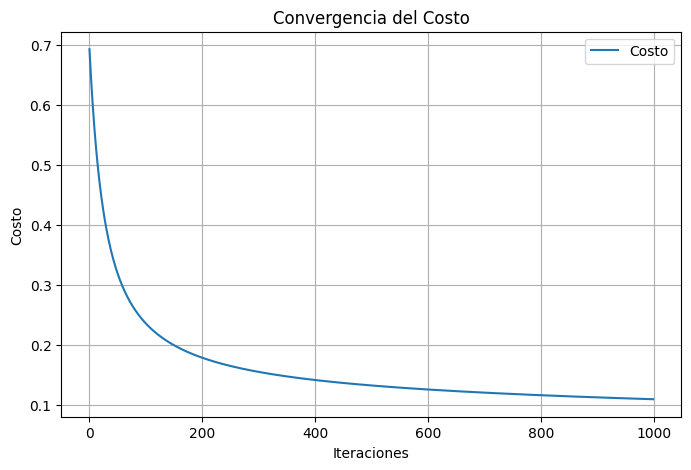


Efectividad del modelo: 97.92%


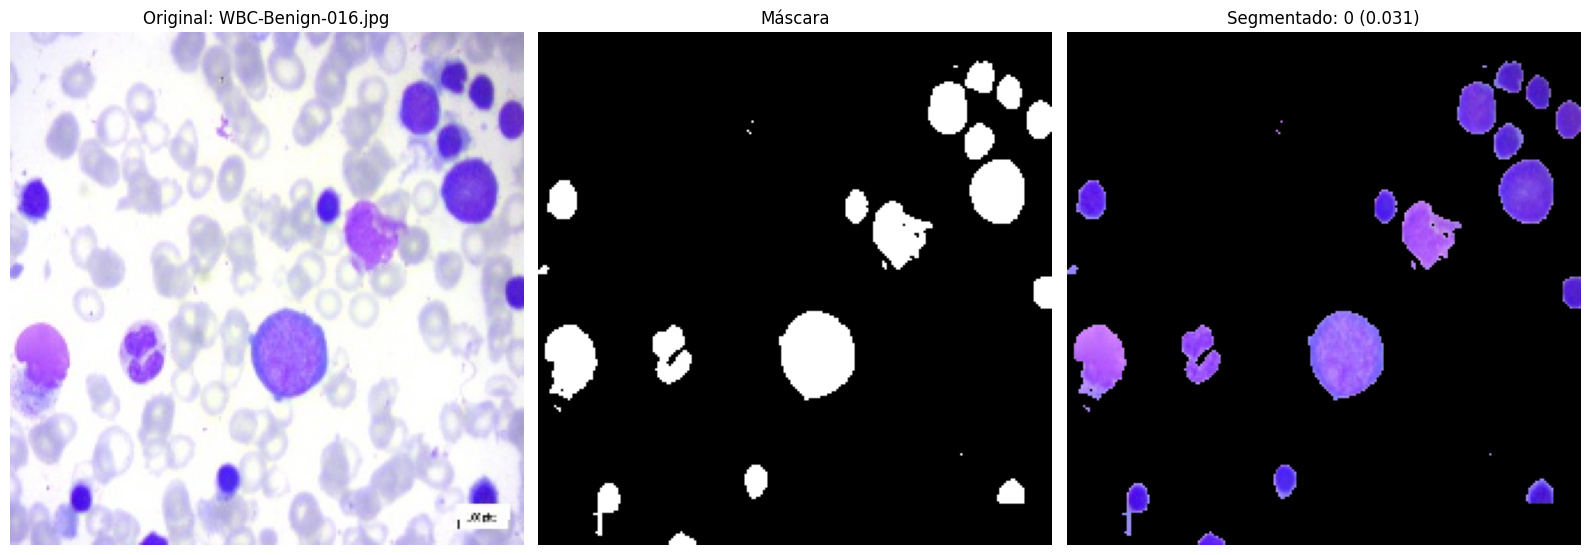

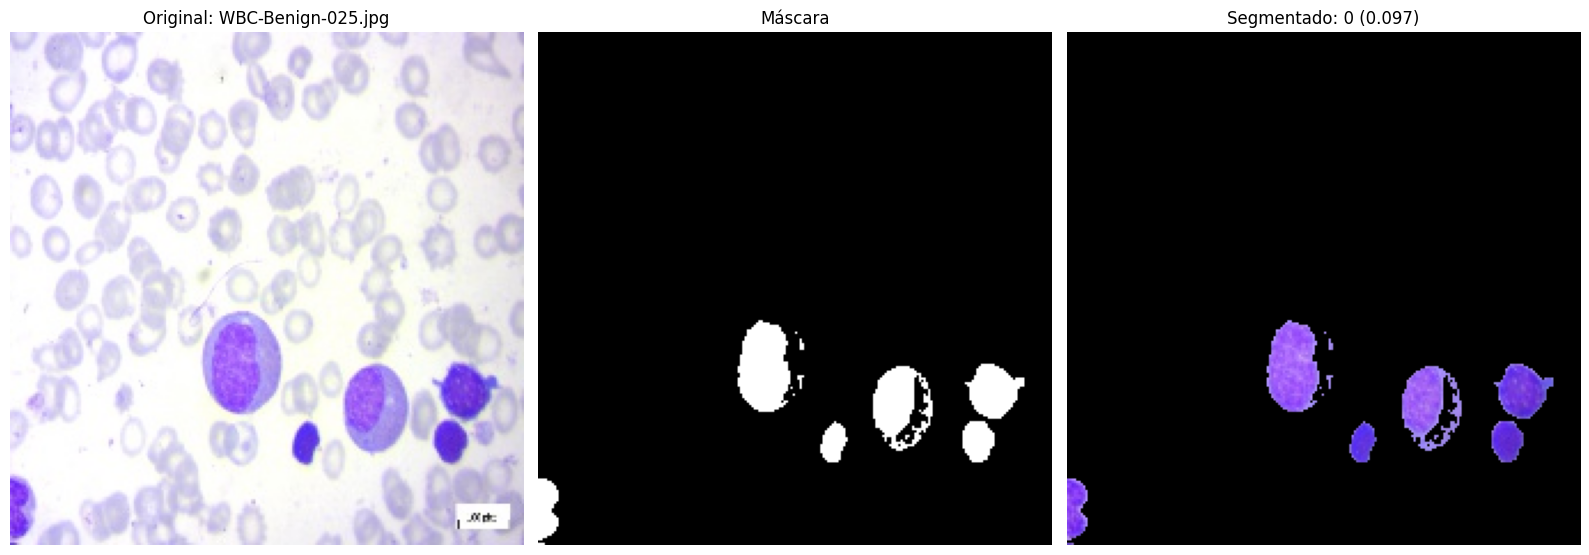

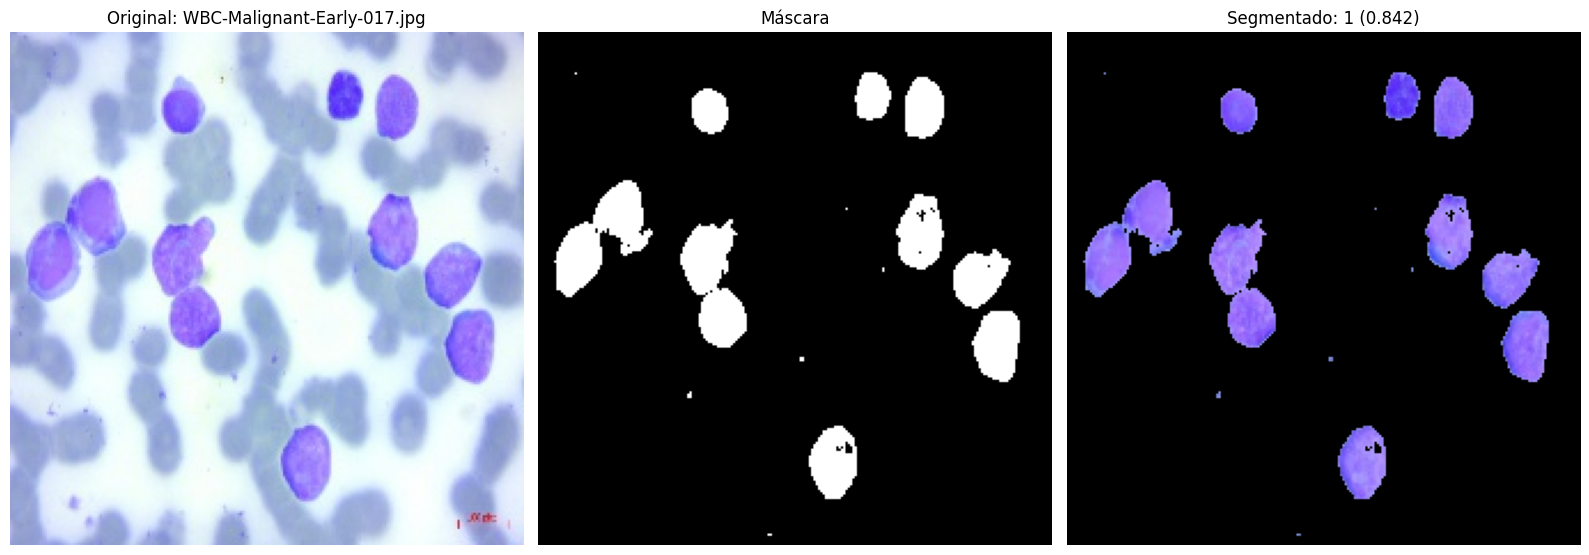

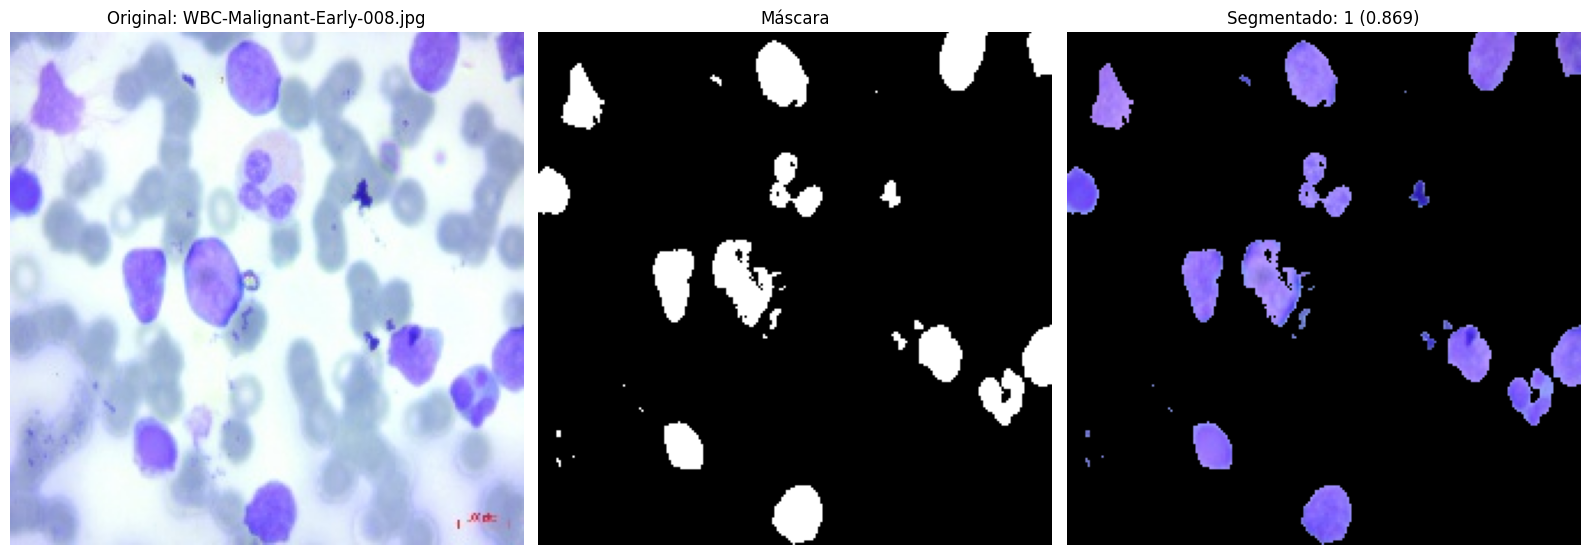

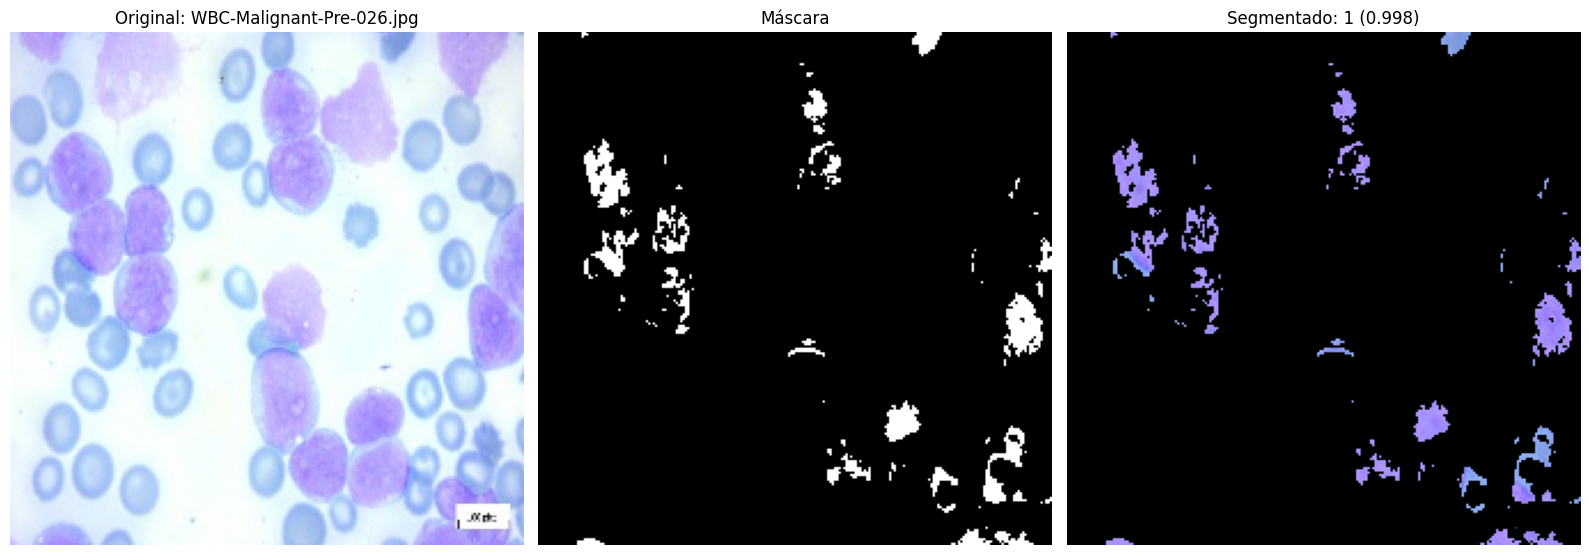

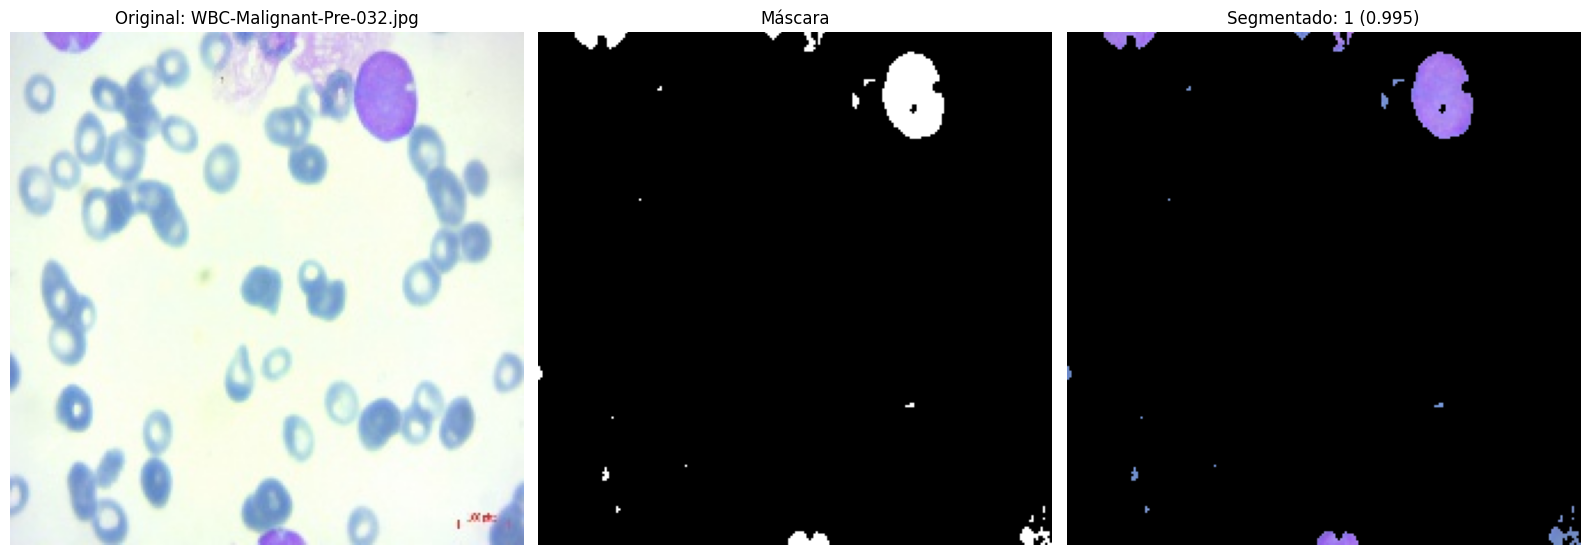


Resultados del análisis:
                     Imagen Probabilidad de Leucemia Predicción  Número de Células Área Promedio Área Total Intensidad Promedio
         WBC-Benign-016.jpg                    0.031       Sano                 12        301.17    3614.00              108.81
         WBC-Benign-025.jpg                    0.097       Sano                  6        362.92    2177.50              112.98
WBC-Malignant-Early-017.jpg                    0.842   Leucemia                  9        487.56    4388.00              137.08
WBC-Malignant-Early-008.jpg                    0.869   Leucemia                 13        313.08    4070.00              140.66
  WBC-Malignant-Pre-026.jpg                    0.998   Leucemia                  5        196.00     980.00              163.07
  WBC-Malignant-Pre-032.jpg                    0.995   Leucemia                  1        717.50     717.50              152.45


In [2]:
# **1. Cargar Datos Iniciales y Preprocesar**
# Carga los datos de los resultados de células sanas y con leucemia.
df_sanas = pd.read_csv('resultados_celulas_sanas.csv')
df_leucemia = pd.read_csv('resultados_celulas_leucemia.csv')

# Etiquetar las células sanas con 0 y las de leucemia con 1.
df_sanas['Etiqueta'] = 0
df_leucemia['Etiqueta'] = 1

# Combinar ambos datasets en uno solo.
df_combinado = pd.concat([df_sanas, df_leucemia])

# Seleccionar las características y la etiqueta objetivo.
X = df_combinado[['Número de Células', 'Área Promedio', 'Área Total', 'Intensidad Promedio (Grises)']].values
y = df_combinado['Etiqueta'].values

# **2. Normalizar las Variables**
# Normaliza las características del dataset para que todas estén en una escala similar.
def normalizar_datos(X, peso_intensidad=3):
    medias = np.mean(X, axis=0)
    desv_est = np.std(X, axis=0)
    X_norm = (X - medias) / desv_est
    X_norm[:, 3] *= peso_intensidad  # Aumentar peso de la intensidad promedio
    return X_norm, medias, desv_est

# Normalizar y guardar estadísticas para su reutilización.
X_norm, medias, desv_est = normalizar_datos(X)

# Agregar un término independiente (bias) a las características normalizadas.
X_norm = np.column_stack([np.ones(len(X)), X_norm])

# **3. Función Sigmoide**
# Define la función sigmoide utilizada en la regresión logística.
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# **4. Regresión Logística con Regularización L1 (LASSO)**
# Implementa la regresión logística entrenando un modelo para clasificar las células.
def regresion_logistica(X, y, alpha=0.01, num_iter=1000, lambda_reg=0.1):
    theta = np.zeros(X.shape[1])
    m = len(y)
    costos = []

    for i in range(num_iter):
        z = np.dot(X, theta)
        h = sigmoid(z)
#stats models, estabilidad

        # Gradiente con regularización L1
        gradiente = np.dot(X.T, (h - y)) / m
        gradiente[1:] += (lambda_reg * np.sign(theta[1:])) / m  # No regularizar el término independiente

        # Actualizar parámetros
        theta -= alpha * gradiente

        # Calcular costo con regularización L1
        costo = -np.mean(y * np.log(h + 1e-10) + (1-y) * np.log(1-h + 1e-10))
        costo += lambda_reg * np.sum(np.abs(theta[1:])) / m
        costos.append(costo)

    return theta, costos

# Entrenar el modelo de regresión logística.
theta, costos = regresion_logistica(X_norm, y, alpha=0.01, num_iter=1000, lambda_reg=0.1)

# **5. Visualizar Convergencia**
# Muestra cómo evoluciona el costo durante el entrenamiento.
plt.figure(figsize=(8, 5))
plt.plot(range(len(costos)), costos, label='Costo')
plt.title('Convergencia del Costo')
plt.xlabel('Iteraciones')
plt.ylabel('Costo')
plt.legend()
plt.grid()
plt.show()

# Hacer predicciones
def predecir(X, theta):
    z = np.dot(X, theta)
    return sigmoid(z)

predicciones = predecir(X_norm, theta) >= 0.5
correctos = np.sum(predicciones == y)
total = len(y)
efectividad = (correctos / total) * 100

print(f"\nEfectividad del modelo: {efectividad:.2f}%")


# **6. Clase para Análisis de Imágenes**
class CellImageAnalyzer:
    def __init__(self, theta, medias, desv_est, factor_intensidad=2.5):
        self.theta = theta
        self.medias = medias
        self.desv_est = desv_est
        self.factor_intensidad = factor_intensidad

    def load_and_display_image(self, image_path):
        img = cv2.imread(image_path)
        if img is not None:
            return img
        else:
            print(f"Error al cargar la imagen {image_path}")
            return None

    def segment_cells(self, image, lower_hue=None, upper_hue=None):
        lower_hue = lower_hue or np.array([110, 100, 50])  # Límites inferiores
        upper_hue = upper_hue or np.array([160, 255, 255])  # Límites superiores
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, lower_hue, upper_hue)
        segmented = cv2.bitwise_and(image, image, mask=mask)
        return mask, segmented

    def analyze_cells(self, mask, image, min_area=100):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cell_data = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > min_area:
                perimeter = cv2.arcLength(contour, True)
                circularity = 4 * np.pi * (area / (perimeter ** 2))
                cell_mask = np.zeros(mask.shape, dtype=np.uint8)
                cv2.drawContours(cell_mask, [contour], -1, 255, thickness=cv2.FILLED)
                mean_intensity_gray = cv2.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), mask=cell_mask)[0]
                cell_info = {
                    'Área': area,
                    'Circularidad': circularity,
                    'Intensidad_Grises': mean_intensity_gray
                }
                cell_data.append(cell_info)
        return cell_data

    def process_and_display_images(self, image_paths, lower_hue=None, upper_hue=None):
        results = []
        for image_path in image_paths:
            image = self.load_and_display_image(image_path)
            if image is None:
                continue

            # Generar máscara y segmento
            mask, segmented = self.segment_cells(image, lower_hue, upper_hue)

            # Analizar células
            cell_data = self.analyze_cells(mask, image)

            if cell_data:
                mean_intensity_gray = np.mean([cell['Intensidad_Grises'] for cell in cell_data])
                num_cells = len(cell_data)
                avg_area = np.mean([cell['Área'] for cell in cell_data])
                total_area = np.sum([cell['Área'] for cell in cell_data])

                # Normalizar las características
                X_nueva = np.array([num_cells, avg_area, total_area, mean_intensity_gray])
                X_norm = (X_nueva - self.medias) / self.desv_est
                X_norm[3] *= self.factor_intensidad
                X_norm = np.concatenate(([1], X_norm))

                # Predicción
                prob = sigmoid(np.dot(X_norm, self.theta))
                pred = 1 if prob >= 0.5 else 0

                # Agregar resultados
                results.append({
                    'Imagen': os.path.basename(image_path),
                    'Probabilidad de Leucemia': f'{prob:.3f}',
                    'Predicción': 'Leucemia' if pred == 1 else 'Sano',
                    'Número de Células': num_cells,
                    'Área Promedio': f'{avg_area:.2f}',
                    'Área Total': f'{total_area:.2f}',
                    'Intensidad Promedio': f'{mean_intensity_gray:.2f}'
                })

                # Mostrar imágenes
                self.display_images(image, mask, segmented, os.path.basename(image_path), prob, pred)

        return pd.DataFrame(results)

    def display_images(self, original, mask, segmented, image_name, prob, pred):
        """Muestra la imagen original, la máscara generada y la imagen segmentada."""
        plt.figure(figsize=(16, 8))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title(f'Original: {image_name}')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Máscara')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
        plt.title(f'Segmentado: {pred} ({prob:.3f})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


# **7. Procesar Varias Imágenes**
# Lista de rutas de imágenes.
image_paths = [
    '/content/drive/MyDrive/archive/Original/Benign/WBC-Benign-016.jpg',
    '/content/drive/MyDrive/archive/Original/Benign/WBC-Benign-025.jpg',
    '/content/drive/MyDrive/archive/Original/Early/WBC-Malignant-Early-017.jpg',
    '/content/drive/MyDrive/archive/Original/Early/WBC-Malignant-Early-008.jpg',
    '/content/drive/MyDrive/archive/Original/Pre/WBC-Malignant-Pre-026.jpg',
    '/content/drive/MyDrive/archive/Original/Pre/WBC-Malignant-Pre-032.jpg'
]

# Instanciar el analizador de imágenes.
analyzer = CellImageAnalyzer(theta, medias, desv_est)

# Procesar todas las imágenes y mostrar resultados.
results_df = analyzer.process_and_display_images(image_paths)

# Mostrar resultados en formato tabla.
print("\nResultados del análisis:")
print(results_df.to_string(index=False))

# Descripción Matemática del Análisis de Células

### 1. Preparación y Etiquetado de Datos

Los datos se dividen en dos grupos con etiquetas binarias:

$$
y_{\text{Sanas}} = 0 \quad \text{y} \quad y_{\text{Leucemia}} = 1
$$

### 2. Variables Predictoras

El modelo utiliza cuatro variables principales:

- $X_1 = \text{Número de Células}$
- $X_2 = \text{Área Promedio}$
- $X_3 = \text{Área Total}$
- $X_4 = \text{Intensidad Promedio}$

### 3. Normalización de Variables

Para cada variable $j$, se calcula:

Media:
$$
\mu_j = \frac{1}{m} \sum_{i=1}^{m} X_{ij}
$$

Desviación estándar:
$$
\sigma_j = \sqrt{\frac{1}{m} \sum_{i=1}^{m} (X_{ij} - \mu_j)^2}
$$

Normalización con peso adicional para intensidad:
$$
X'_{ij} = \begin{cases}
\frac{X_{ij} - \mu_j}{\sigma_j} & \text{para } j = 1,2,3 \\
\frac{X_{ij} - \mu_j}{\sigma_j} \times 3 & \text{para } j = 4
\end{cases}
$$

### 4. Matriz de Características

La matriz final incluye el término independiente:

$$
X = \begin{bmatrix}
1 & X'_{11} & X'_{12} & X'_{13} & X'_{14} \\
1 & X'_{21} & X'_{22} & X'_{23} & X'_{24} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1 & X'_{m1} & X'_{m2} & X'_{m3} & X'_{m4}
\end{bmatrix}
$$

### 5. Función Sigmoide

La transformación sigmoide se define como:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

donde $z = \theta^T X$

### 6. Función de Costo con Regularización L1

La función de costo incluye el término de regularización L1:

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y_i \log(h_\theta(x_i)) + (1-y_i)\log(1-h_\theta(x_i))] + \frac{\lambda}{m} \sum_{j=1}^{n} |\theta_j|
$$

Donde:
- $h_\theta(x_i) = \sigma(\theta^T x_i)$
- $\alpha$ = velocidad de convergencia y estabilidad
- $\lambda$ = parámetro de regularización
- $m$ = número de muestras
- $n$ = número de características

### 7. Actualización de Parámetros

Los parámetros se actualizan mediante:

$$
\theta_j := \theta_j - \alpha \left[\frac{1}{m} \sum_{i=1}^{m} (h_\theta(x_i) - y_i)x_{ij} + \frac{\lambda}{m} \text{sign}(\theta_j)\right]
$$

### 8. Predicción Final

Para una nueva muestra, la predicción se realiza:

$$
\text{predicción} = \begin{cases}
1 \text{ (Leucemia)} & \text{si } \sigma(\theta^T X) \geq 0.5 \\
0 \text{ (Sana)} & \text{si } \sigma(\theta^T X) < 0.5
\end{cases}
$$

### 9. Evaluación del Modelo

La efectividad se calcula como:

$$
\text{Efectividad} = \frac{\text{Predicciones correctas}}{\text{Total de predicciones}} \times 100\%
$$

1. Cálculo de Vector entre Puntos
*Fórmula:* Vector = [x₂ - x₁, y₂ - y₁]
- Resta las coordenadas de dos puntos consecutivos
- Determina dirección y sentido del movimiento

2. Magnitud del Vector
*Fórmula:* |v| = √(x² + y²)
- Calcula la longitud del vector
- Usa el teorema de Pitágoras
- Mide la distancia recorrida

3. Producto Punto de Vectores
*Fórmula:* v₁ · v₂ = x₁x₂ + y₁y₂
- Multiplica componentes x e y de dos vectores
- Ayuda a determinar la similitud entre vectores

4. Ángulo entre Vectores
*Fórmula:* θ = arccos((v₁ · v₂) / (|v₁| * |v₂|))
- Calcula el ángulo de cambio de dirección
- Compara la orientación de vectores consecutivos
- Fundamental para decidir qué puntos conservar

# Producto Punto en Regresión Logística

$$
z = X\theta = \begin{bmatrix} 1 & x_1 & x_2 & x_3 & x_4 \end{bmatrix} \begin{bmatrix} \theta_0 \\ \theta_1 \\ \theta_2 \\ \theta_3 \\ \theta_4 \end{bmatrix} = \theta_0 \cdot 1 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 + \theta_3 \cdot x_3 + \theta_4 \cdot x_4
$$

Donde:
- $x_1$: Número de Células (normalizado)
- $x_2$: Área Promedio (normalizada)
- $x_3$: Área Total (normalizada)
- $x_4$: Intensidad Promedio en Grises (normalizada y ponderada)
- $\theta_0$: Término independiente o sesgo (bias)
- $\theta_1, \theta_2, \theta_3, \theta_4$: Coeficientes para cada característica

## Significado en el Contexto del Modelo

1. **Combinación Lineal**
   - Cada característica $x_i$ se pondera por su importancia relativa $\theta_i$
   - El término independiente $\theta_0$ añade un sesgo base

2. **Interpretación de los Coeficientes**
   - $\theta_i > 0$: La característica aumenta la probabilidad de leucemia
   - $\theta_i < 0$: La característica disminuye la probabilidad de leucemia
   - $|\theta_i|$: Magnitud del impacto de la característica

3. **Flujo del Modelo**
   $$
   X\theta \xrightarrow{\text{producto punto}} z \xrightarrow{\text{sigmoide}} h_\theta(x) = \frac{1}{1 + e^{-z}}
   $$

4. **Resultado**
   - $z$: Puntuación lineal (puede ser cualquier número real)
   - $h_\theta(x)$: Probabilidad entre 0 y 1 después de aplicar la sigmoide

La regularización L1 (también conocida como LASSO - Least Absolute Shrinkage and Selection Operator) es una técnica para prevenir el sobreajuste (overfitting).

### ¿Qué es la regularización L1?

Es un término que se añade a la función de costo:

$$
\frac{\lambda}{m} \sum_{j=1}^{n} |\theta_j|
$$

Donde:
- λ (lambda) es el parámetro que controla la fuerza de la regularización
- m es el número de muestras
- θj son los parámetros del modelo
- |θj| es el valor absoluto de cada parámetro

### ¿Por qué se implementa?

1. Prevención de sobreajuste:
   - Penaliza coeficientes muy grandes que podrían hacer que el modelo se ajuste demasiado a los datos de entrenamiento
   - Ayuda al modelo a generalizar mejor con nuevos datos

2. Selección de características:
   - La regularización L1 tiende a producir coeficientes exactamente iguales a cero
   - Esto efectivamente selecciona las características más importantes y descarta las menos relevantes

### Efectos prácticos:

1. Con lambda_reg = 0:
   - No hay regularización
   - El modelo puede sobreajustarse

2. Con lambda_reg pequeño (ej: 0.1):
   - Regularización suave
   - Balance entre ajuste y generalización

3. Con lambda_reg grande (ej: 10):
   - Regularización fuerte
   - Más coeficientes se vuelven cero
   - Modelo más simple pero puede subajustarse (underfitting)

### Ventajas:

1. Selección automática de características más relevantes para detectar leucemia
2. Reducción del ruido en las mediciones de células
3. Modelo más robusto y generalizable a nuevas muestras
4. Interpretabilidad mejorada al identificar las características más importantes


# Fórmulas Geométricas para Análisis de Contornos

## 1. Área del Contorno

El área de un contorno cerrado se calcula utilizando la fórmula del área de un polígono mediante coordenadas:

$$
\text{Área} = \frac{1}{2} \sum_{i=1}^{n} (x_i y_{i+1} - y_i x_{i+1})
$$

Donde:
- $n$ : Número total de puntos en el contorno
- $(x_i, y_i)$ : Coordenadas del punto $i$ del contorno
- $(x_{i+1}, y_{i+1})$ : Coordenadas del siguiente punto en el contorno
- El punto $n+1$ se considera igual al punto 1, cerrando el polígono

Esta fórmula:
- Utiliza el método de triangulación para calcular el área
- Funciona para cualquier polígono cerrado, sea cóncavo o convexo
- El resultado es positivo si los puntos están ordenados en sentido antihorario
- El valor absoluto del resultado da el área real

## 2. Perímetro del Contorno

El perímetro se calcula sumando las distancias entre todos los puntos consecutivos del contorno:

$$
\text{Perímetro} = \sum_{i=1}^{n} \sqrt{(x_{i+1} - x_i)^2 + (y_{i+1} - y_i)^2}
$$

Donde:
- $n$ : Número total de puntos en el contorno
- $(x_i, y_i)$ : Coordenadas del punto actual
- $(x_{i+1}, y_{i+1})$ : Coordenadas del siguiente punto
- El último punto se conecta con el primero para cerrar el contorno

Esta fórmula:
- Utiliza la distancia euclidiana entre puntos consecutivos
- La suma total representa la longitud del contorno completo
- Es independiente de la orientación del contorno

## 3. Circularidad

La circularidad es una medida adimensional que cuantifica qué tan similar es una forma a un círculo perfecto:

$$
\text{Circularidad} = \frac{4\pi \times \text{Área}}{\text{Perímetro}^2}
$$

Donde:
- $\text{Área}$ : Área del contorno calculada con la primera fórmula
- $\text{Perímetro}$ : Perímetro del contorno calculado con la segunda fórmula
- $\pi$ : Constante matemática pi (≈ 3.14159)

Interpretación de los valores:
- $\text{Circularidad} = 1$ : Círculo perfecto
- $0 < \text{Circularidad} < 1$ : Formas no circulares
  - Valores cercanos a 1: Formas casi circulares
  - Valores cercanos a 0: Formas muy alargadas o irregulares

Propiedades importantes:
1. Es invariante a la escala (el tamaño no afecta el resultado)
2. Es adimensional (no tiene unidades)
3. Siempre es menor o igual a 1 (la igualdad solo se da en círculos perfectos)
4. Es sensible a irregularidades en el contorno

Ejemplo de interpretación:
- Circularidad = 0.95: Forma muy circular
- Circularidad = 0.7: Forma moderadamente circular
- Circularidad = 0.3: Forma muy irregular o alargadas

# Regresión Logística

La **regresión logística** es un método de clasificación utilizado para predecir la probabilidad de una clase binaria (0 o 1). A diferencia de la regresión lineal, que predice un valor continuo, la regresión logística modela la probabilidad de una clase como una función de la combinación lineal de las características.

## Función Logística

La función logística, o función sigmoide, se define como:

$$
P(y = 1|x) = \frac{1}{1 + e^{-(w^T x + b)}}
$$

Donde:
- \( P(y = 1|x) \) es la probabilidad de que la clase sea 1 dado un vector de características \( x \).
- \( w \) es el vector de pesos del modelo.
- \( b \) es el sesgo o término independiente.
- \( x \) es el vector de características de entrada.

La función sigmoide convierte la salida lineal \( w^T x + b \) en un valor entre 0 y 1, que puede interpretarse como una probabilidad.

## Función de Costo

Para entrenar el modelo, se utiliza la función de costo de entropía cruzada:

$$
J(w, b) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(P(y^{(i)}|x^{(i)})) + (1 - y^{(i)}) \log(1 - P(y^{(i)}|x^{(i)})) \right]
$$

Donde:
- \( m \) es el número total de ejemplos en el conjunto de datos.
- \( y^{(i)} \) es la etiqueta verdadera para el i-ésimo ejemplo.
- \( P(y^{(i)}|x^{(i)}) \) es la probabilidad predicha para el i-ésimo ejemplo.

## Gradientes y Actualización

Los gradientes de la función de costo con respecto a los parámetros \( w \) y \( b \) se utilizan para actualizar los pesos y el sesgo mediante descenso por gradiente:

- **Gradiente del peso \( w \):**

$$
\frac{\partial J(w, b)}{\partial w} = \frac{1}{m} \sum_{i=1}^{m} (P(y^{(i)}|x^{(i)}) - y^{(i)}) x^{(i)}
$$

- **Gradiente del sesgo \( b \):**

$$
\frac{\partial J(w, b)}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (P(y^{(i)}|x^{(i)}) - y^{(i)})
$$

Los parámetros se actualizan de la siguiente manera:

- **Actualización del peso \( w \):**

$$
w := w - \alpha \frac{\partial J(w, b)}{\partial w}
$$

- **Actualización del sesgo \( b \):**

$$
b := b - \alpha \frac{\partial J(w, b)}{\partial b}
$$

Donde \( \alpha \) es la tasa de aprendizaje.

La precisión del modelo se evalúa comparando las predicciones con las etiquetas verdaderas en el conjunto de prueba, utilizando métricas como la precisión (accuracy), precisión (precision), sensibilidad (recall), y especificidad.

# Contraste de Resultados
Este modelo basado en aprendizaje profundo alcanzó una precisión, sensibilidad y especificidad de 99,85, 99,52 y 99,89 %, respectivamente. El método propuesto puede ayudar a distinguir la LLA de los casos benignos.

Se utilizó un conjunto de datos específico que contenía 3256 imágenes PBS de 89 pacientes sospechosos de LLA

En el enfoque propuesto, mediante el uso de un método de bajo costo, primero se segmentaron las células blásticas y luego, cada dos conjuntos de imágenes iniciales y segmentadas pasaron al procesamiento.

El paso de procesamiento consiste en descodificación, cambio de tamaño, normalización y aumento. Después del preprocesamiento preliminar de las imágenes, cada dos grupos de imágenes, es decir, cada par de imágenes de muestra y su versión segmentada, se utilizaron como entrada para la arquitectura.

La arquitectura del modelo propuesto comprendía dos secciones generales. Un bloque de extracción de características basado en DenseNet-201 este estaba a cargo de la extracción de características.

Las características extraídas de la imagen principal y sus células segmentadas correspondientes se concatenaron e ingresaron al bloque de clasificación, que fue responsable de la clasificación de los datos en grupos benignos y malignos, con tres subtipos de LLA: pre-B, pre-B temprana y pro-B. [4]

# Conclusiones

1. Desempeño del modelo: El modelo ha alcanzado un desempeño notable con una precisión del 86.6% para las imágenes sanas y del 85.4% para las imágenes con leucemia. Esto sugiere que el modelo es bastante eficaz en la clasificación binaria entre imágenes sanas y con leucemia, con una ligera diferencia en el rendimiento entre ambas clases.

2. Equilibrio entre las clases: Aunque existe una pequeña variación entre la precisión en las imágenes sanas y las de leucemia, ambas precisiones están bastante cerca, lo que indica que el modelo está generalizando bien a ambas clases sin sesgarse excesivamente hacia una u otra.

3. Posible mejora en la precisión global: Aunque las precisiones son buenas, hay un margen para mejorar el modelo. La diferencia entre las precisiones para imágenes sanas y con leucemia puede estar relacionada con la calidad o complejidad de las características extraídas de las imágenes de leucemia, lo que podría sugerir que el modelo tiene más dificultad para capturar patrones específicos de la leucemia.

4. Impacto del preprocesamiento y la extracción de características: La buena precisión en general puede estar atribuida a un adecuado preprocesamiento de las imágenes y la extracción de características relevantes que permiten al modelo diferenciar entre las clases de manera efectiva. Sin embargo, la diferencia en las precisiones puede indicar que algunas características clave podrían necesitar un ajuste para mejorar la discriminación en las imágenes con leucemia.

# Referencias:
1. Cáncer en la niñez y la adolescencia - OPS/OMS | Organización Panamericana de la Salud [Internet]. 2024 [citado 1 de diciembre de 2024]. Disponible en: https://www.paho.org/es/temas/cancer-ninez-adolescencia
2. Estadísticas importantes sobre la leucemia en niños [Internet]. [citado 1 de diciembre de 2024]. Disponible en: https://www.cancer.org/es/cancer/tipos/leucemia-en-ninos/acerca/estadisticas-clave.html
3. Leukemia & Lymphoma Society. Leucemia linfoblástica aguda (ALL) [Internet]. 2024 [citado 2024 Dec 1]. Disponible en: https://www.lls.org/sites/default/files/2024-08/PS62S_ALL_2024_spanish.pdf
4. Ghaderzadeh, M, Aria, M, Hosseini, A, Asadi, F, Bashash, D, Abolghasemi, H. A fast and efficient CNN model for B-ALL diagnosis and its subtypes classification using peripheral blood smear images. Int J Intell Syst. 2022; 37: 5113- 5133. doi:10.1002/int.22753